In [1]:
# Need to load in a comet-stacked image in one of the bands for one of the days.
# Need to rotate image to align tail with x-axis, this can be done manually.
# A perpendicular section can be taken through the optocentre (found using ctk.FindCometCentre).
# A similar section of a nearby field star is also taken (important that this is taken from the rotated image).
# Plot these profiles against distance in arcseconds. They should be normalised.
# If the bare nuculeus is observed, the comet profile will match the star profile in the centre up to a point.
# The wings will be slightly higher, indicating a coma contamination.

In [2]:
import numpy as np
import cometToolkit as ctk
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import scipy

from uncertainties import ufloat

from natsort import natsorted
from glob import glob

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from astroquery.jplhorizons import Horizons

mpl.rcParams.update({'font.size': 14})


In [3]:
reducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/Day13/R/*"))[:-2]

i=0

starsImage = cometImage = ctk.GetImage(reducedDataPaths[i])

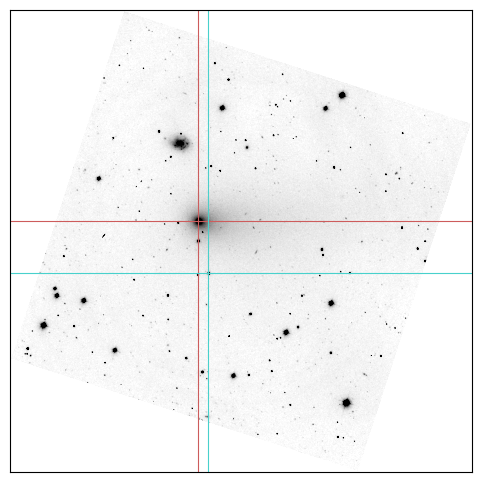

In [4]:
r = -18

cometRotated = scipy.ndimage.rotate(cometImage, r)
starsRotated = scipy.ndimage.rotate(starsImage, r)

sources = ctk.SearchStars(starsRotated)

tol = 50
for source in sources:

    # chosing star
    if ((source["xcentroid"] - 1150)**2 < tol**2) and ((source["ycentroid"] - 1500)**2 < tol**2):
        starCentre = (source["xcentroid"], source["ycentroid"])

    # Chosing Comet
    if ((source["xcentroid"] - 1050)**2 < tol**2) and ((source["ycentroid"] - 1150)**2 < tol**2):
        cometCentre = (source["xcentroid"], source["ycentroid"])

#starCentre =(400, 850)

fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(cometRotated, vmin=280, vmax=400, cmap="binary")

ax.hlines([cometCentre[1]], xmin=0, xmax=len(cometRotated), color="indianred", lw=0.8)
ax.vlines([cometCentre[0]], ymin=0, ymax=len(cometRotated), color="indianred", lw=0.8)

ax.hlines([starCentre[1]], xmin=0, xmax=len(cometRotated), color="mediumturquoise", lw=0.8)
ax.vlines([starCentre[0]], ymin=0, ymax=len(cometRotated), color="mediumturquoise", lw=0.8)

ax.margins(0)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig("../../Writing/Thesis/images/rotated_image.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_8461/2411031815.py:32: RuntimeWarning: divide by zero encountered in log10
  ax.plot(relativeCometPositions, np.log10(cometProfile), color="indianred", label="Comet Profile")
/tmp/ipykernel_8461/2411031815.py:33: RuntimeWarning: divide by zero encountered in log10
  ax.plot(relativeStarPositions + [offset]*len(relativeStarPositions), np.log10(starProfile), color="mediumturquoise", label="Star Profile")


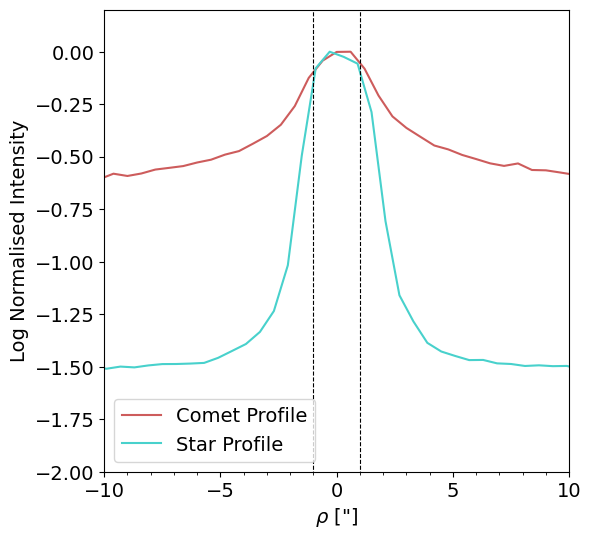

In [5]:
# Get perpendicular profiles

# Comet
cometProfilePosition = round(cometCentre[0])
cometProfile = np.mean(cometRotated[:,cometProfilePosition - 1 : cometProfilePosition + 2], axis=1)

# Star
starProfilePosition = round(starCentre[0])
starProfile = np.mean(starsRotated[:,starProfilePosition - 1 : starProfilePosition + 2], axis=1)


def PixelToArcsec(px):
    return 0.6 * px

def ArcsecToPx(arcsec):
    return arcsec / 0.6

relativeCometPositions = np.array([PixelToArcsec(el - round(cometCentre[1])) for el in range(len(cometProfile))])
relativeStarPositions = np.array([PixelToArcsec(el - round(starCentre[1])) for el in range(len(starProfile))])


# Normalising
centreTolerance = 5

cometProfile = [el/np.max(cometProfile[np.where(relativeCometPositions < centreTolerance)]) for el in cometProfile]
starProfile = [el/np.max(starProfile[np.where(relativeStarPositions < centreTolerance)]) for el in starProfile]

offset = 0.3

fig, ax = plt.subplots(figsize=(6,6))

ax.plot(relativeCometPositions, np.log10(cometProfile), color="indianred", label="Comet Profile")
ax.plot(relativeStarPositions + [offset]*len(relativeStarPositions), np.log10(starProfile), color="mediumturquoise", label="Star Profile")

nucleusPoint = 1
ax.vlines([-nucleusPoint, nucleusPoint], ymin=-3.5, ymax=1, ls="dashed", lw=0.8, color="black")

ax.set_xlim(-10, 10)
ax.set_ylim(-2, 0.2)
ax.set_ylabel("Log Normalised Intensity")
ax.set_xlabel(r'$\rho$ ["]')

ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.legend()

plt.savefig("../../Writing/Thesis/images/comet_vs_star_profile.pdf", format="pdf", bbox_inches="tight")

In [24]:
# Now we need to determine the coma correction.
# Note, coma correction cannot be calculated for the centre, as we are at the seeing limit
# 
# This will be calculated from the surface brightness. (See O'Ceallaigh 1995)
# Or, the total magnitude with this centre point masked? Maybe??

Hit


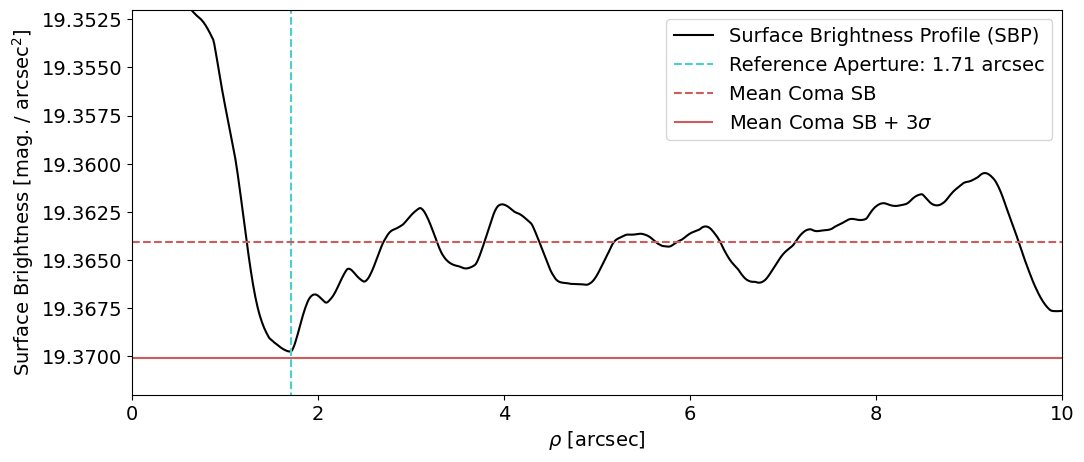

In [7]:
# Making surface brightness profile

rZeroPoint = 20.32
rZeroPointError = 0.10

annulusSize = 0.6 # arcsec
minRad = annulusSize
maxRad = 80
annulusRadii = np.linspace(minRad, maxRad, round(50 * maxRad / annulusSize))

innerRadii = [ArcsecToPx(el - annulusSize / 2) for el in annulusRadii]
outerRadii = [ArcsecToPx(el + annulusSize / 2) for el in annulusRadii]

areas = [np.pi * (outer**2 - inner**2) for outer, inner in zip(outerRadii, innerRadii)]

apertures = [CircularAnnulus(cometCentre, inn   er, outer) for outer, inner in zip(outerRadii, innerRadii)]

phot_table = aperture_photometry(cometImage, apertures)

sbp = [-2.5 * np.log10(phot_table[0][i+3] / (120 * areas[i])) + rZeroPoint for i in range(len(annulusRadii))]

# Plotting

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(annulusRadii, sbp, color="black", label="Surface Brightness Profile (SBP)")
ax.set_xlabel(r"$\rho$ [arcsec]")
ax.set_ylabel(r"Surface Brightness [mag. / arcsec$^2$]")
plt.gca().invert_yaxis()

# Fitting to the flat part to find coma correction
i = 50
surfaceBrightness = ufloat(np.mean(sbp[i:]), np.std(sbp[i:]))

for r, sb in zip(annulusRadii, sbp):
    if sb > (surfaceBrightness.n + 0 * surfaceBrightness.s):
        print("Hit")
        comaStartIndex = np.where(annulusRadii == r)[0][0]
        break

comaStartIndex = np.argmax(sbp)

ax.vlines([annulusRadii[comaStartIndex]], ymin=np.min(sbp), ymax=19.372, color="mediumturquoise",
            ls="dashed", label=f"Reference Aperture: {annulusRadii[comaStartIndex]:.2f} arcsec")

ax.hlines([surfaceBrightness.n], xmin=0, xmax=maxRad, colors="indianred",
            ls="dashed", label=f"Mean Coma SB")
ax.hlines([surfaceBrightness.n + 3 * surfaceBrightness.s], xmin=0, xmax=maxRad, colors="indianred",
            ls="solid", label="Mean Coma SB + 3$\sigma$")

ax.margins(0)
ax.legend()
ax.set_xlim(0, 10)
ax.set_ylim(19.372, 19.352)

plt.savefig("../../Writing/Thesis/images/surface_brightness.pdf", format="pdf", bbox_inches="tight")

In [26]:
comaCorrection = surfaceBrightness - 2.5 * np.log10(2 * np.pi * annulusRadii[comaStartIndex]**2)

# Find "total magnitude"

aperture = CircularAperture(cometCentre, ArcsecToPx(annulusRadii[comaStartIndex]))

phot_table = aperture_photometry(cometImage, aperture)

totalMag = -2.5 * np.log10(phot_table["aperture_sum"][0] / 120) + rZeroPoint

nucleusMag = totalMag - 2.5 * np.log10( 1 - 10**(-0.4 * (comaCorrection.n - totalMag)))
print(f"r_N = {nucleusMag}")
print(f"total mag = {totalMag}")


# Variable comet distance
body = Horizons(id=90000670, location="500@3", epochs={"2024-03-14"})
vectors = body.vectors()
earthDistance = vectors["range"][0] # au

body = Horizons(id=90000670, location="500@10", epochs={"2024-03-14"})
vectors = body.vectors()
heliocentricDistance = vectors["range"][0] # au


A = 0.04
beta = 0.035
phase = 9
solarMagnitude = -27.1
radius = (1 / A) * np.sqrt(2.24 * 10**22 * heliocentricDistance**2 * earthDistance**2 * 10**(0.4 * (solarMagnitude - nucleusMag + beta * phase))) / 1000

print(f"R = {radius:.3f} km") # km

r_N = 17.222094267010817
total mag = 15.847076697326177
R = 5.481 km


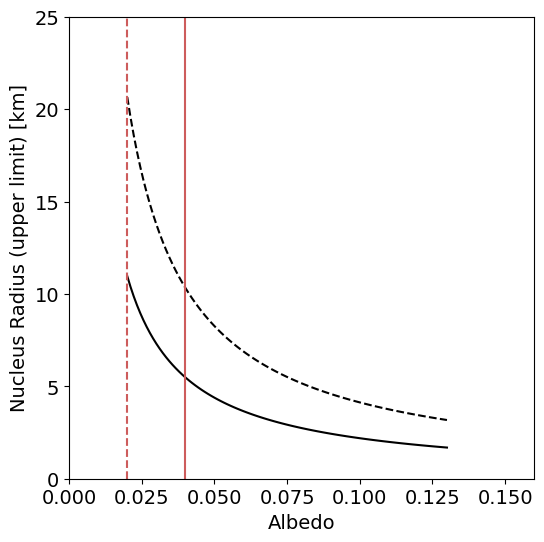

In [27]:
# Radius Curve -> Make sure to reference vertical lines, and describe the differences between the dashed and solid lines
# As there are assumptions made of the grain albedo, a 'radius curve' is a more appropriate result.
# Radius is determined with a range of albedo values corresponding to literature measurments.

albedos = np.linspace(0.02, 0.13, 100)
radii = []
upperRadii = []
for albedo in albedos:
    radii.append( 0.001 * (1 / albedo) * np.sqrt(2.24 * 10**22 * heliocentricDistance**2 * earthDistance**2 * 10**(0.4 * (solarMagnitude - nucleusMag + beta * phase))))
    upperRadii.append( 0.001 * (1 / albedo) * np.sqrt(2.24 * 10**22 * heliocentricDistance**2 * earthDistance**2 * 10**(0.4 * (solarMagnitude - totalMag + beta * phase))))


fig, ax = plt.subplots(figsize=(6,6))

ax.plot(albedos, radii, color="black")
ax.plot(albedos, upperRadii, color="black", ls="dashed")

ax.vlines([0.02, 0.04], ymin=0, ymax=25, colors="indianred", ls=["dashed", "-"])
ax.set_xlabel("Albedo")
ax.set_ylabel("Nucleus Radius (upper limit) [km]")
ax.margins(y=0)
ax.set_xlim(0, 0.16)

plt.savefig("../../Writing/Thesis/images/radius_curve.pdf", format="pdf", bbox_inches="tight")